In [ ]:
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
from  IPython import display

import pathlib
import shutil
import tempfile

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots
from sklearn.model_selection import  train_test_split

print("Version: ", tf.__version__)
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

  Preparing metadata (setup.py) ... done
Version:  2.15.0
Hub version:  0.16.1
GPU is available


## Download and Import the Quora Insincere Questions Dataset

A downloadable copy of the [Quora Insincere Questions Classification data](https://www.kaggle.com/c/quora-insincere-questions-classification/data) can be found [https://archive.org/download/fine-tune-bert-tensorflow-train.csv/train.csv.zip](https://archive.org/download/fine-tune-bert-tensorflow-train.csv/train.csv.zip). Decompress and read the data into a pandas DataFrame.

## General Description About The Dataset
In this dataset we will be predicting whether a question asked on Quora is sincere or not.

An insincere question is defined as a question intended to make a statement rather than look for helpful answers. Some characteristics that can signify that a question is insincere:

**Has a non-neutral tone:**

- Has an exaggerated tone to underscore a point about a group of people
- Is rhetorical and meant to imply a statement about a group of people

**Is disparaging or inflammatory:**

- Suggests a discriminatory idea against a protected class of people, or seeks confirmation of a stereotype
- Makes disparaging attacks/insults against a specific person or group of people
- Based on an outlandish premise about a group of people
- Disparages against a characteristic that is not fixable and not measurable

**Isn't grounded in reality:**

- Based on false information, or contains absurd assumptions
- Uses sexual content (incest, bestiality, pedophilia) for shock value, and not to seek genuine answers


The training data includes the question that was asked, and whether it was identified as insincere (target = 1). The ground-truth labels contain some amount of noise: they are not guaranteed to be perfect.

Note that the distribution of questions in the dataset should not be taken to be representative of the distribution of questions asked on Quora. This is, in part, because of the combination of sampling procedures and sanitization measures that have been applied to the final dataset.

In [ ]:
df = pd.read_csv('https://archive.org/download/fine-tune-bert-tensorflow-train.csv/train.csv.zip',
                 compression='zip', low_memory=False)
df.shape

(1306122, 3)

The number of spam samples is 80810 and not spam samples is 1225312 



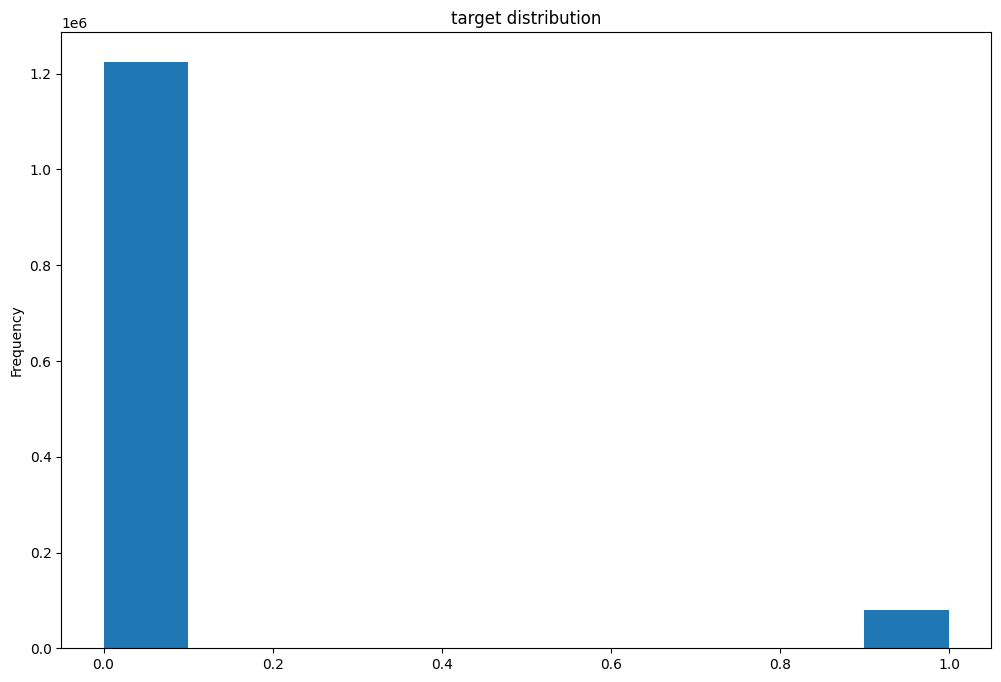

In [ ]:
class_counts = df['target'].value_counts()

print(f'The number of spam samples is {class_counts[1]} and not spam samples is {class_counts[0]} \n')

df['target'].plot(kind='hist', title= 'target distribution');


In [ ]:
# Choosing small dataset
train_df , remaining = train_test_split(df, random_state=42, train_size=0.01, stratify=df.target.values)
print(train_df.shape, remaining.shape)
valid_df, _ = train_test_split(remaining, random_state=42, train_size=0.001, stratify=remaining.target.values)

train_df.shape , valid_df.shape

(13061, 3) (1293061, 3)


((13061, 3), (1293, 3))

In [ ]:
train_df.target.head(15).values, train_df.question_text.head(15).values


(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]),
 array(['What is your experience living in Venezuela in the current crisis? (2018)',
        'In which state/city the price of property is highest?',
        'Do rich blacks also call poor whites, “White Trash”?',
        'Should my 5 yr old son and 2 yr old daughter spend the summer with their father, after a domestic violent relationship?',
        'Why do we have parents?',
        'Do we experience ghost like Murphy did in Interstellar?',
        'Are Estoniano women beautiful?',
        'There was a Funny or Die video called Sensitivity Hoedown that got pulled. Does anyone know why?',
        'Is it a good idea to go in fully mainstream classes, even if I have meltdowns that might disrupt people?',
        'What classifies a third world country as such?',
        'Is being a pilot safe?',
        'Who is Illiteratendra Modi? Why does he keep with him a Rs 1 lakh pen?',
        'Have modern management strategies such as Total s

## TensorFlow Hub for Natural Language Processing

Our text data consits of questions and corresponding labels.

You can think of a question vector as a distributed representation of a question, and is computed for every question in the training set. The question vector along with the output label is then used to train the statistical classification model.

The intuition is that the question vector captures the semantics of the question and, as a result, can be effectively used for classification.

To obtain question vectors, we have two alternatives that have been used for several text classification problems in NLP:
* word-based representations and
* context-based representations

#### Word-based Representations

- A **word-based representation** of a question combines word embeddings of the content words in the question. We can use the average of the word embeddings of content words in the question. Average of word embeddings have been used for different NLP tasks.
- Examples of pre-trained embeddings include:
  - **Word2Vec**: These are pre-trained embeddings of words learned from a large text corpora. Word2Vec has been pre-trained on a corpus of news articles with  300 million tokens, resulting in 300-dimensional vectors.
  - **GloVe**: has been pre-trained on a corpus of tweets with 27 billion tokens, resulting in 200-dimensional vectors.


#### Context-based Representations

- **Context-based representations** may use language models to generate vectors of sentences. So, instead of learning vectors for individual words in the sentence, they compute a vector for sentences on the whole, by taking into account the order of words and the set of co-occurring words.
- Examples of deep contextualised vectors include:
  - **Embeddings from Language Models (ELMo)**: uses character-based word representations and bidirectional LSTMs. The pre-trained model computes a contextualised vector of 1024 dimensions. ELMo is available on Tensorflow Hub.
  - **Universal Sentence Encoder (USE)**: The encoder uses a Transformer  architecture that uses attention mechanism to incorporate information about the order and the collection of words. The pre-trained model of USE that returns a vector of 512 dimensions is also available on Tensorflow Hub.
  - **Neural-Net Language Model (NNLM)**: The model simultaneously learns representations of words and probability functions for word sequences, allowing it to capture semantics of a sentence. We will use a  pretrained  models available on Tensorflow Hub, that are trained on the English Google News 200B corpus, and computes a vector of 128 dimensions for the larger model and 50 dimensions for the smaller model.


Transfer learning makes it possible to save training resources and to achieve good model generalization even when training on a small dataset. In this project, we will demonstrate this by training with several different TF-Hub modules.

## Define Function to Build and Compile Models

In [ ]:
def train_and_evaluate_model(module_url, embed_size, name, trainable=False):
  hub_layer = hub.KerasLayer(module_url, input_shape=[], output_shape=[embed_size], dtype=tf.string, trainable=trainable)
  model = tf.keras.models.Sequential([
                                      hub_layer,
                                      tf.keras.layers.Dense(256, activation='relu'),
                                      tf.keras.layers.Dense(64, activation='relu'),
                                      tf.keras.layers.Dense(1, activation='sigmoid')
  ])


  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # using low lr to prevent overfit with our pretrained emmbeding layer

                loss=tf.losses.BinaryCrossentropy(),
                metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy')])
  model.summary()
  history = model.fit(train_df['question_text'], train_df['target'],
                      epochs=3,
                      batch_size = 32,
                      validation_data=(valid_df['question_text'], valid_df['target']),
                      callbacks=[tfdocs.modeling.EpochDots(),
                                 tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min'),
                                 tf.keras.callbacks.TensorBoard(logdir/name)],
                      verbose=1)
  return history



## Train Various Text Classification Models

In [ ]:
histories = {} # a place to save all ourr models performance and compare them to each otrhes

In [ ]:
# Choosing from various avaliable word embeddings from tensorflow hub
module_url = "https://tfhub.dev/google/universal-sentence-encoder-large/5" #@param ["https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1", "https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1", "https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1", "https://tfhub.dev/google/universal-sentence-encoder/4", "https://tfhub.dev/google/universal-sentence-encoder-large/5"] {allow-input: true}

In [ ]:
histories['universal-sentence-encoder-large'] = train_and_evaluate_model(module_url, embed_size=512,
                                                                     name='universal-sentence-encoder-large',
                                                                     trainable=False)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 512)               147354880 
                                                                 
 dense_3 (Dense)             (None, 256)               131328    
                                                                 
 dense_4 (Dense)             (None, 64)                16448     
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 147502721 (562.68 MB)
Trainable params: 147841 (577.50 KB)
Non-trainable params: 147354880 (562.11 MB)
_________________________________________________________________
Epoch 1/3
  6/409 [..............................] - ETA: 24s - loss: 0.6727 - accuracy: 0.8854

408/409 [============================>.] - ETA: 0s - loss: 0.2942 - accuracy: 0.9366
Epoch: 0, accuracy:0.9366,  loss:0.2941,  val_accuracy:0.9381,  val_loss:0.1666,  
409/409 [==============================] - 50s 63ms/step - loss: 0.2941 - accuracy: 0.9366 - val_loss: 0.1666 - val_accuracy: 0.9381
Epoch 2/3
409/409 [==============================] - 23s 55ms/step - loss: 0.1404 - accuracy: 0.9399 - val_loss: 0.1380 - val_accuracy: 0.9466
Epoch 3/3
409/409 [==============================] - 21s 50ms/step - loss: 0.1181 - accuracy: 0.9519 - val_loss: 0.1286 - val_accuracy: 0.9474


## Task 8: Compare Accuracy and Loss Curves

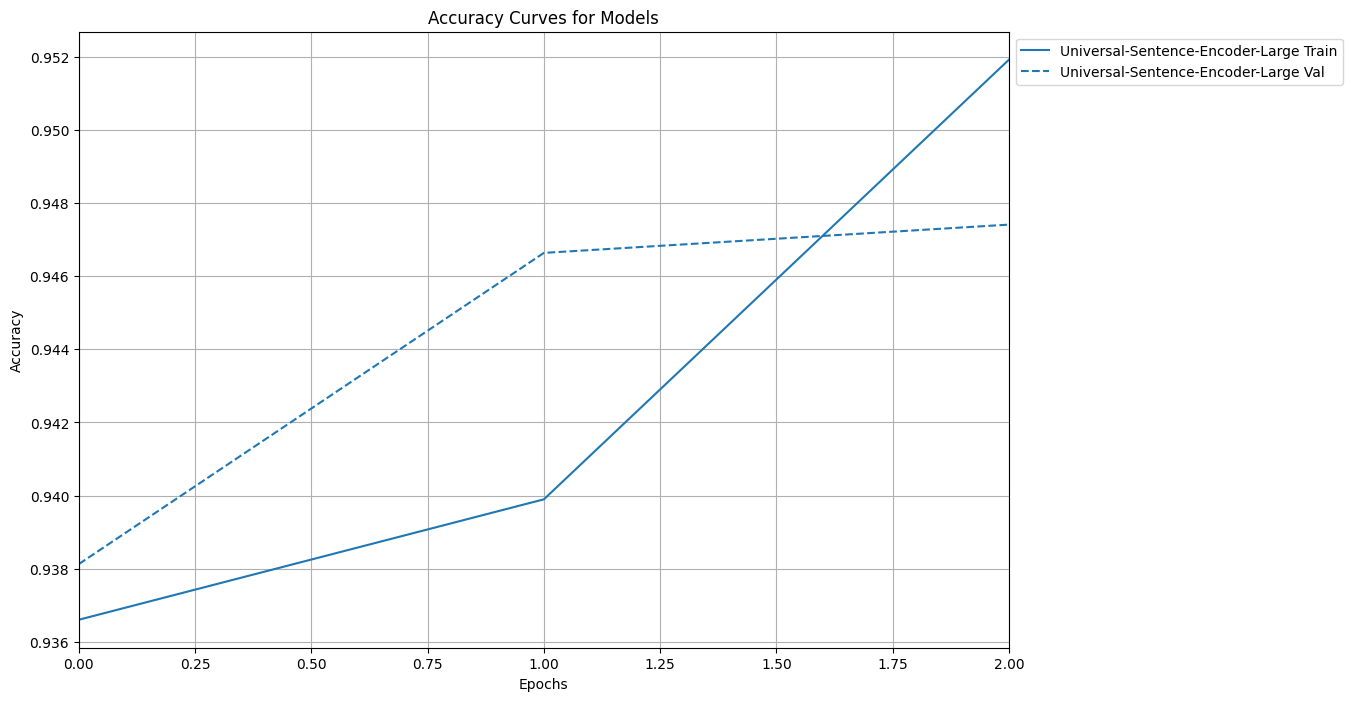

In [ ]:
plt.rcParams['figure.figsize'] = (12, 8)
plotter = tfdocs.plots.HistoryPlotter(metric = 'accuracy')
plotter.plot(histories)
plt.xlabel("Epochs")
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
plt.title("Accuracy Curves for Models")
plt.show()

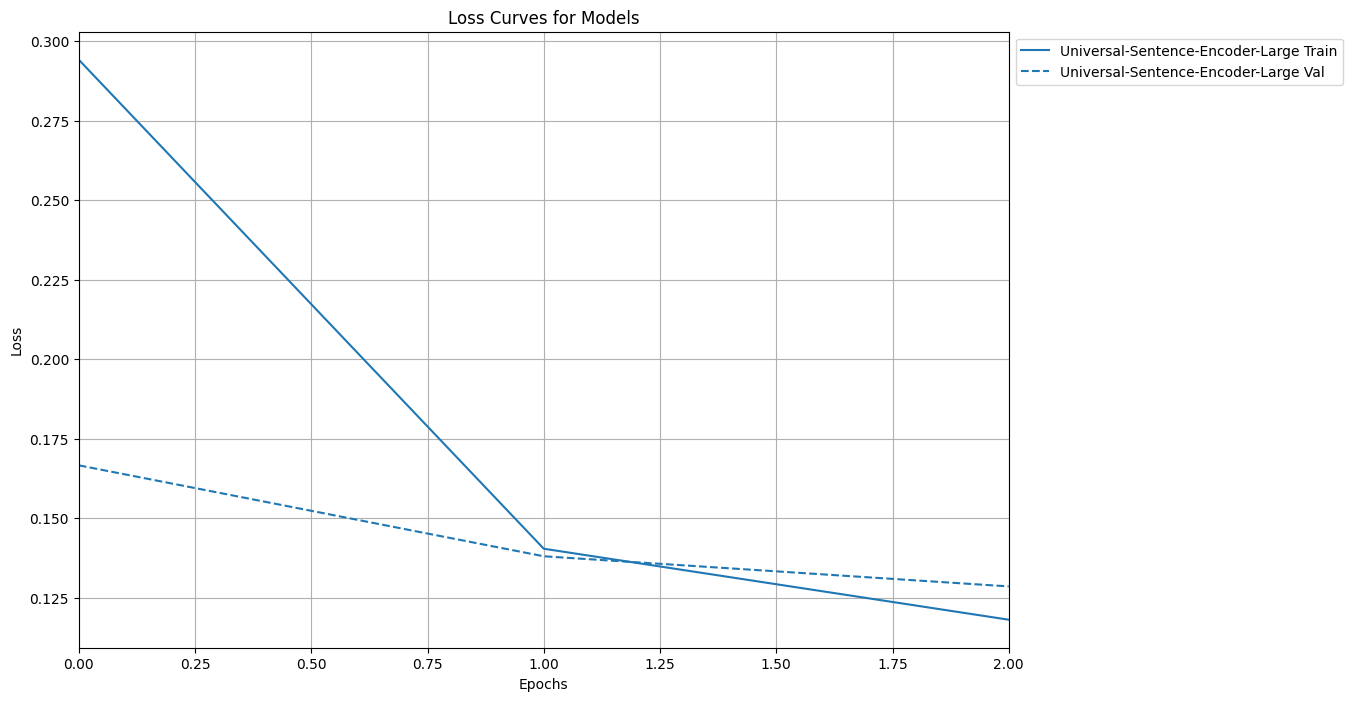

In [ ]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'loss')
plotter.plot(histories)
plt.xlabel("Epochs")
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
plt.title("Loss Curves for Models")
plt.show()